In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# Import necessary modules for file and directory manipulation
import os

# Set the base directory for the small dataset
base_dir = './dog_cats_small'

# Define directories for training, validation, and test sets
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Create directories for cat and dog classes within each set
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

val_cats_dir = os.path.join(val_dir, 'cats')
val_dogs_dir = os.path.join(val_dir, 'dogs')

test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')
# Display the count of images in each class for training, validation, and test sets
print('Total training cat images:', len(os.listdir(train_cats_dir)))
print('Total validation cat images:', len(os.listdir(val_cats_dir)))
print('Total test cat images:', len(os.listdir(test_cats_dir)))

print('Total training dogs images:', len(os.listdir(train_dogs_dir)))
print('Total validation dogs images:', len(os.listdir(val_dogs_dir)))
print('Total test dogs images:', len(os.listdir(test_dogs_dir)))

Total training cat images: 1000
Total validation cat images: 500
Total test cat images: 500
Total training dogs images: 1000
Total validation dogs images: 500
Total test dogs images: 500


In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(180, 180),
    batch_size=64,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(180, 180),
    batch_size=64,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [7]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Conv2D(32, 5, use_bias=False, activation='relu')(inputs)

for size in [64, 128, 256, 512]:
    residual = x
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(size, 3, padding='same', use_bias=False)(x)
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(size, 3, padding='same', use_bias=False)(x)
    
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    
    residual = layers.Conv2D(size, 1, strides=2, padding='same', use_bias=False)(residual)
    x = layers.add([x, residual])
    
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [8]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 conv2d_5 (Conv2D)           (None, 176, 176, 32)         2400      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_8 (Bat  (None, 176, 176, 32)         128       ['conv2d_5[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation_8 (Activation)   (None, 176, 176, 32)         0         ['batch_normalization_8[

In [11]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit(train_generator, 
                    epochs=100, 
                    validation_data=test_generator, 
                    callbacks=[
                        keras.callbacks.ModelCheckpoint(save_best_only=True, filepath='modern_convnet.keras', monitor='val_loss')
                    ])

Epoch 1/100
32/32 [==============================] - 11s 268ms/step - loss: 0.5654 - accuracy: 0.7080 - val_loss: 0.6592 - val_accuracy: 0.6165
Epoch 2/100
32/32 [==============================] - 9s 271ms/step - loss: 0.5329 - accuracy: 0.7410 - val_loss: 1.2135 - val_accuracy: 0.5440
Epoch 3/100
32/32 [==============================] - 9s 264ms/step - loss: 0.5440 - accuracy: 0.7190 - val_loss: 0.6870 - val_accuracy: 0.6015
Epoch 4/100
32/32 [==============================] - 9s 265ms/step - loss: 0.5228 - accuracy: 0.7465 - val_loss: 0.7273 - val_accuracy: 0.6030
Epoch 5/100
32/32 [==============================] - 9s 264ms/step - loss: 0.5238 - accuracy: 0.7390 - val_loss: 0.6603 - val_accuracy: 0.6655
Epoch 6/100
32/32 [==============================] - 8s 258ms/step - loss: 0.5128 - accuracy: 0.7540 - val_loss: 2.7479 - val_accuracy: 0.5200
Epoch 7/100
32/32 [==============================] - 9s 273ms/step - loss: 0.5108 - accuracy: 0.7560 - val_loss: 0.6117 - val_accuracy: 0.686

In [13]:
model = keras.applications.xception.Xception(weights='imagenet')

91884032/91884032 [==============================] - 4s 0us/step


733657/733657 [==============================] - 2s 2us/step


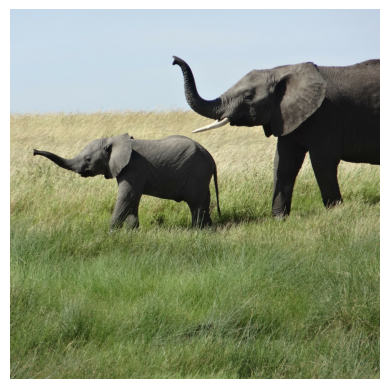

In [32]:
import numpy as np
import matplotlib.pyplot as plt

img_path = keras.utils.get_file('elephant.jpg', origin='https://img-datasets.s3.amazonaws.com/elephant.jpg')

image = plt.imread(img_path)
plt.axis('off')
plt.imshow(image)

In [33]:
def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis = 0)
    array = keras.applications.xception.preprocess_input(array)
    return array

img_array = get_img_array(img_path, target_size=(299, 299))

In [34]:
preds = model.predict(img_array)
print(keras.applications.xception.decode_predictions(preds, top=3)[0])


1/1 [==============================] - 0s 11ms/step
[('n02504458', 'African_elephant', 0.870266), ('n01871265', 'tusker', 0.07674813), ('n02504013', 'Indian_elephant', 0.023496488)]


In [35]:
np.argmax(preds[0])

386

In [36]:
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "avg_pool",
    "predictions",
]
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(inputs=model.inputs, outputs=last_conv_layer.output)

In [37]:
classifier_input = keras.Input(shape=last_conv_layer.output_shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(inputs=classifier_input, outputs=x)

In [39]:
import tensorflow as tf

with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]
    
grads = tape.gradient(top_class_channel, last_conv_layer_output)

In [40]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
heatmap = np.mean(last_conv_layer_output, axis=-1)

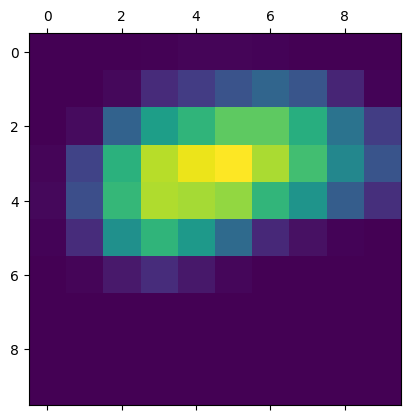

In [41]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

/tmp/ipykernel_141905/2035825928.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap('jet')


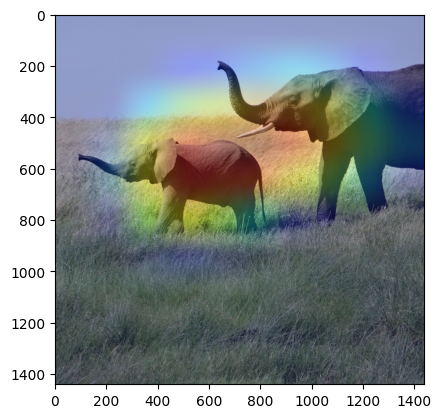

In [45]:
import matplotlib.cm as cm

img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)
heatmap = np.uint8(255 * heatmap)

jet = cm.get_cmap('jet')
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)

plt.imshow(superimposed_img)